## By DHAYANITHI T

# Project Description:

1. In this project, a bank has designated delinquent customers into different recovery strategies based on their expected recovery amounts. This assignment is not random and is determined by a threshold.
2. The objective is to assess whether assigning customers to a higher recovery strategy resulted in a greater increase in the bank's earnings compared to the additional costs incurred. 
3. This type of threshold assignment is also observed in other domains such as medicine, education, finance, and the public sector. 
4. Regression discontinuity is a valuable analysis method in situations involving threshold assignments, allowing for intuitive and useful insights.

## 1. Regression discontinuity: banking recovery

After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply walks away from the debt. They still want to collect some of the money they are owed. The bank will score the account to assess the expected recovery amount, that is, the expected amount that the bank may be able to receive from the customer in the future (for a fixed time period such as one year). This amount is a function of the probability of the customer paying, the total debt, and other factors that impact the ability and willingness to pay.

The bank has implemented different recovery strategies at different thresholds ($1000, $2000, etc.) where the greater the expected recovery amount, the more effort the bank puts into contacting the customer. For low recovery amounts (Level 0), the bank just adds the customer's contact information to their automatic dialer and emailing system. For higher recovery strategies, the bank incurs more costs as they leverage human resources in more efforts to contact the customer and obtain payments. Each additional level of recovery strategy requires an additional $50 per customer so that customers in the Recovery Strategy Level 1 cost the company $50 more than those in Level 0. Customers in Level 2 cost $50 more than those in Level 1, etc.

The big question: does the extra amount that is recovered at the higher strategy level exceed the extra $50 in costs? In other words, was there a jump (also called a "discontinuity") of more than $50 in the amount recovered at the higher strategy level? We'll find out in this notebook.

### Importing Modules

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the Dataset

In [2]:
df = pd.read_csv('bank_data.csv')

In [3]:
df

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540000,Level 0 Recovery,19,Male
1,1150,486,416.090000,Level 0 Recovery,25,Female
2,380,527,429.350000,Level 0 Recovery,27,Male
3,1838,536,296.990000,Level 0 Recovery,25,Male
4,1995,541,346.385000,Level 0 Recovery,34,Male
...,...,...,...,...,...,...
1877,361,9785,15388.195990,Level 4 Recovery,65,Female
1878,196,9857,9709.909257,Level 4 Recovery,68,Female
1879,313,9859,30209.181790,Level 4 Recovery,58,Female
1880,1781,9920,20386.232190,Level 4 Recovery,67,Female


In [4]:
df.isnull().sum()

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1882 non-null   int64  
 1   expected_recovery_amount  1882 non-null   int64  
 2   actual_recovery_amount    1882 non-null   float64
 3   recovery_strategy         1882 non-null   object 
 4   age                       1882 non-null   int64  
 5   sex                       1882 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 88.3+ KB


## Graphical exploratory data analysis

The bank has implemented different recovery strategies at different thresholds ($1000, $2000, $3000 and $5000) where the greater the Expected Recovery Amount, the more effort the bank puts into contacting the customer. Zeroing in on the first transition (between Level 0 and Level 1) means we are focused on the population with Expected Recovery Amounts between $0 and $2000 where the transition between Levels occurred at $1000.

We know that the customers in Level 1 (expected recovery amounts between $1001 and $2000) received more attention from the bank and, by definition, they had higher Expected Recovery Amounts than the customers in Level 0 (between $1 and $1000).


Here's a quick summary of the Levels and thresholds again:
Level 0: Expected recovery amounts >$0 and <=$1000
Level 1: Expected recovery amounts >$1000 and <=$2000
The threshold of $1000 separates Level 0 from Level 1


A key question is whether there are other factors besides Expected Recovery Amount that also varied systematically across the $1000 threshold. For example, does the customer age show a jump (discontinuity) at the $1000 threshold or does that age vary smoothly? We can examine this by first making a scatter plot of the age as a function of Expected Recovery Amount for a small window of Expected Recovery Amount, $0 to $2000. This range covers Levels 0 and 1.

In [6]:
df.age.value_counts().max()

82

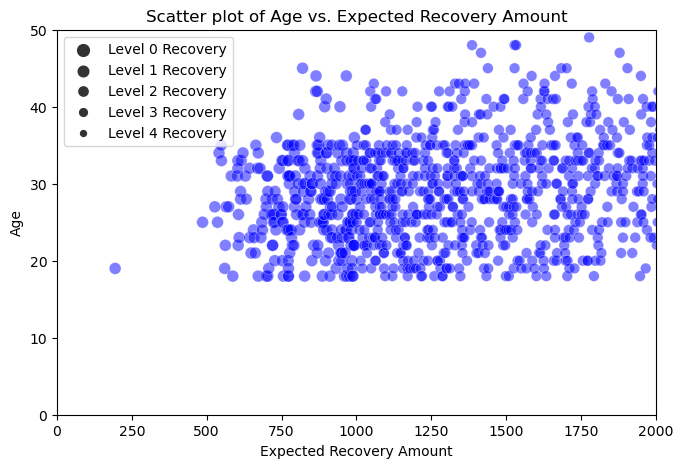

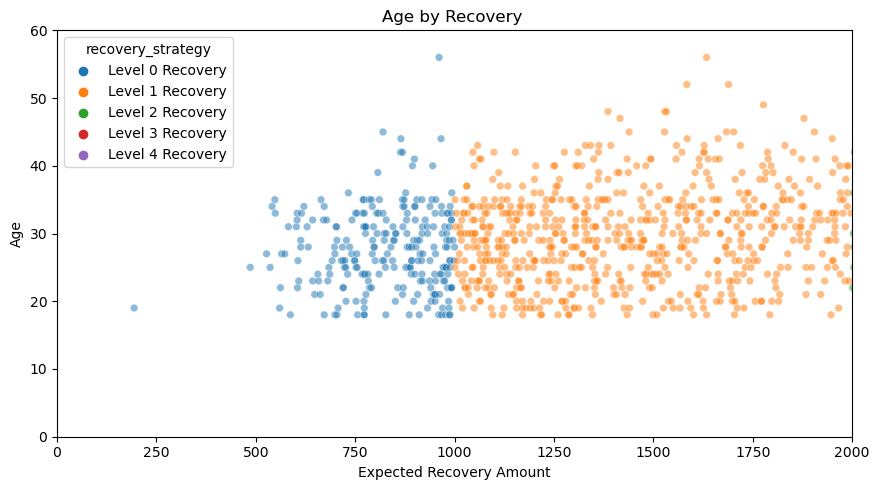

In [7]:
plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='expected_recovery_amount', y='age',color = 'b',size='recovery_strategy',s=2, alpha=0.5, marker='o')
plt.xlim(0, 2000)
plt.ylim(0, 50)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.title('Scatter plot of Age vs. Expected Recovery Amount')
plt.legend(loc=2)
plt.show()

plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='expected_recovery_amount', y='age', hue='recovery_strategy', alpha=0.5, marker='o', s=30)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.title("Age by Recovery ")

plt.tight_layout()
plt.show()



By visually inspecting the scatter plot, one can observe whether there is a distinct change or discontinuity in the age of customers at the $1000 threshold or if the age varies smoothly across the range of expected recovery amounts.

## Statistical test: age vs. expected recovery amount

We want to convince ourselves that variables such as age and sex are similar above and below the $1000 Expected Recovery Amount threshold. This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.


The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around $1000. We will be more confident in our conclusions if we do statistical analysis examining the average age of the customers just above and just below the threshold.

We can start by exploring the range from $900 to $1100.

In [8]:
from scipy import stats

# Compute average age just below and above the threshold
ERA = df[(df['expected_recovery_amount'] < 1100) & (df['expected_recovery_amount'] >= 900)]
average_age = ERA.groupby('recovery_strategy')['age'].mean()

# Display average age by recovery strategy
average_age = pd.DataFrame(average_age)
average_age.columns = ['Average Age']
average_age

# Perform Kruskal-Wallis test
Level_0_age = ERA.loc[ERA['recovery_strategy'] == "Level 0 Recovery", 'age']
Level_1_age = ERA.loc[ERA['recovery_strategy'] == "Level 1 Recovery", 'age']
kruskal_result = stats.kruskal(Level_0_age, Level_1_age)
kruskal_result



KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

In [9]:
# Perform one-way ANOVA
anova_result = stats.f_oneway(Level_0_age, Level_1_age)

# Print the ANOVA test result
print("One-way ANOVA p-value:", anova_result.pvalue)


One-way ANOVA p-value: 0.09297868115283987


The anova_result object contains the test result, including the calculated F-statistic and the associated p-value. You can access the p-value using anova_result.pvalue. A small p-value indicates significant differences between the group means.

## Statistical test: sex vs. expected recovery amount

We were able to convince ourselves that there is no major jump in the average customer age just above and just below the $1000 threshold by doing a statistical test as well as exploring it graphically with a scatter plot.


We want to also test that the percentage of customers that are male does not jump as well across the $1000 threshold. We can start by exploring the range of $900 to $1100 and later adjust this range.

In [10]:
# Filter the DataFrame based on the expected recovery amount range
filtered_df = df[(df['expected_recovery_amount'] < 1100) & (df['expected_recovery_amount'] >= 900)]

# Create a contingency table (crosstab) of recovery strategy and sex
crosstab = pd.crosstab(filtered_df['recovery_strategy'], filtered_df['sex'])
print(crosstab)

# Chi-square test
chi2_stat, p_val = stats.chisquare(crosstab)
print("Chi-square test statistic:", chi2_stat)
print("p-value:", p_val)


sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55
Chi-square test statistic: [0.69014085 0.03571429]
p-value: [0.40611648 0.85010674]


## Exploratory graphical analysis: recovery amount

We are now reasonably confident that customers just above and just below the $1000 threshold are, on average, similar in terms of their average age and the percentage that are male.


It is now time to focus on the key outcome of interest, the actual recovery amount.


A first step in examining the relationship between the actual recovery amount and the expected recovery amount is to develop a scatter plot where we want to focus our attention at the range just below and just above the threshold. Specifically, we will develop a scatter plot of Expected Recovery Amount (Y) vs. Actual Recovery Amount (X) for Expected Recovery Amounts between $900 to $1100. This range covers Levels 0 and 1. A key question is whether or not we see a discontinuity (jump) around the $1000 threshold.

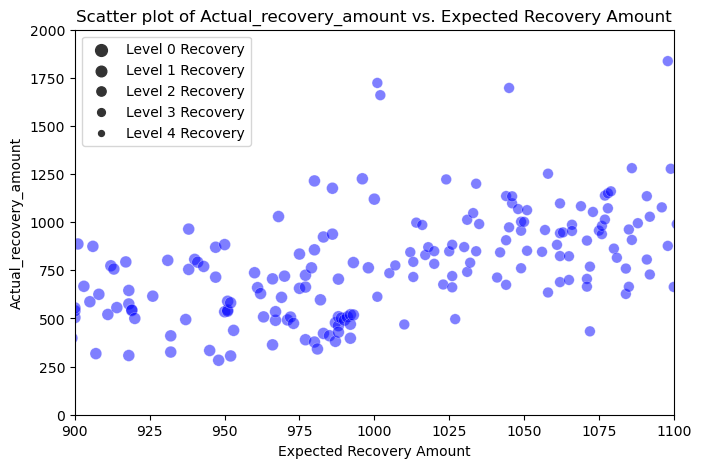

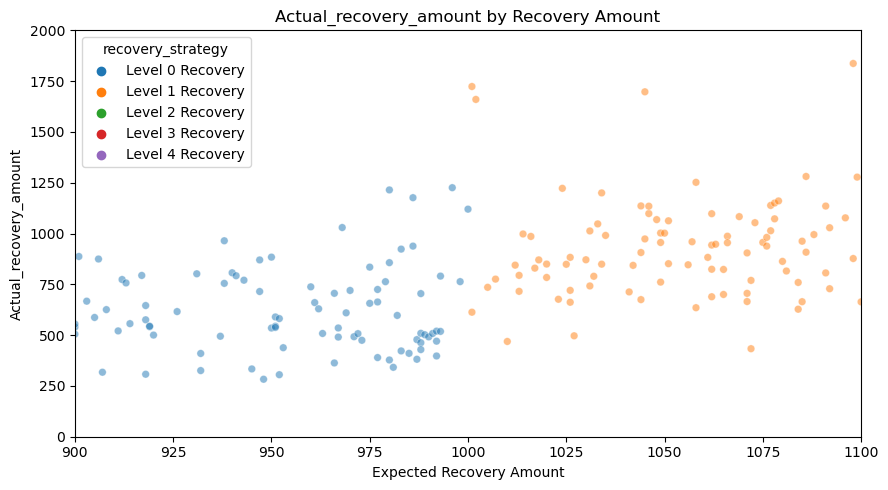

In [11]:
plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='expected_recovery_amount', y='actual_recovery_amount',color = 'b',size='recovery_strategy',s=2, alpha=0.5, marker='o')
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual_recovery_amount")
plt.title('Scatter plot of Actual_recovery_amount vs. Expected Recovery Amount')
plt.legend(loc=2)
plt.show()

plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='expected_recovery_amount', y='actual_recovery_amount', hue='recovery_strategy', alpha=0.5, marker='o', s=30)
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual_recovery_amount")
plt.title("Actual_recovery_amount by Recovery Amount")

plt.tight_layout()
plt.show()


## Statistical analysis: recovery amount

Just as we did with age, we can perform statistical tests to see if the actual recovery amount has a discontinuity above the $1000 threshold. We are going to do this for two different windows of the expected recovery amount $900 to $1100 and for a narrow range of $950 to $1050 to see if our results are consistent.


Again, the statistical test we will use is the Kruskal-Wallis test, a test that makes no assumptions about the distribution of the actual recovery amount.

In [12]:
import pandas as pd
from scipy import stats

# Compute average actual recovery amount just below and above the threshold
average_actual_recovery = ERA.groupby('recovery_strategy')['actual_recovery_amount'].describe()
print(average_actual_recovery)
print('')

# Perform Kruskal-Wallis test
Level_0_actual = ERA.loc[ERA['recovery_strategy'] == 'Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = ERA.loc[ERA['recovery_strategy'] == 'Level 1 Recovery']['actual_recovery_amount']
kruskal_result = stats.kruskal(Level_0_actual, Level_1_actual)
print(kruskal_result)
print('')

# Repeat for a smaller range of $950 to $1050
era_950_1050 = df[(df['expected_recovery_amount'] < 1050) & (df['expected_recovery_amount'] >= 950)]
Level_0_actual_950_1050 = era_950_1050.loc[era_950_1050['recovery_strategy'] == 'Level 0 Recovery']['actual_recovery_amount']
Level_1_actual_950_1050 = era_950_1050.loc[era_950_1050['recovery_strategy'] == 'Level 1 Recovery']['actual_recovery_amount']
kruskal_result_950_1050 = stats.kruskal(Level_0_actual_950_1050, Level_1_actual_950_1050)
print(kruskal_result_950_1050)


                   count        mean         std         min         25%  \
recovery_strategy                                                          
Level 0 Recovery    89.0  623.017022  211.620859  282.855000  491.425000   
Level 1 Recovery    94.0  955.825551  293.732434  433.199166  777.705154   

                          50%          75%          max  
recovery_strategy                                        
Level 0 Recovery   575.435000   762.995000  1225.660000  
Level 1 Recovery   907.271525  1060.334387  2053.290126  

KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)

KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)


## Regression modeling: no threshold

We now want to take a regression-based approach to estimate the impact of the program at the $1000 threshold using the data that is just above and just below the threshold. In order to do that, we will build two models. The first model does not have a threshold while the second model will include a threshold.


The first model predicts the actual recovery amount (outcome or dependent variable) as a function of the expected recovery amount (input or independent variable). We expect that there will be a strong positive relationship between these two variables.

In [13]:
# Import statsmodels
import statsmodels.api as sm

# Define X and y
X = ERA['expected_recovery_amount']
y = ERA['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Tue, 18 Jul 2023   Prob (F-statistic):           1.56e-13
Time:                            20:08:19   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression modeling: adding true threshold

From the first model, we see that the regression coefficient is statistically significant for the expected recovery amount and the adjusted R-squared value was about 0.26. 

As we saw from the graph, on average the actual recovery amount increases as the expected recovery amount increases. We could add polynomial terms of expected recovery amount (such as the squared value of expected recovery amount) to the model but, for the purposes of this practice, let's stick with using just the linear term.


The second model adds an indicator of the true threshold to the model. If there was no impact of the higher recovery strategy on the actual recovery amount, then we would expect that the relationship between the expected recovery amount and the actual recovery amount would be continuous.

In [14]:
# Create indicator variable
df['indicator_1000'] = np.where(df['expected_recovery_amount'] < 1000, 0, 1)

# Filter the DataFrame based on the expected recovery amount range
ERA_2 = df[(df['expected_recovery_amount'] < 1100) & (df['expected_recovery_amount'] >= 900)]

# Define X and y
X = ERA_2[['expected_recovery_amount', 'indicator_1000']]
y = ERA_2['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()

# Print out the model summary statistics
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Tue, 18 Jul 2023   Prob (F-statistic):           1.83e-15
Time:                            20:08:19   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        3.3440    626.274      0.005      0.996   -1232.440    1239.128
expected_recovery_amount     0.6430      0.655      0.981      0.328      -0.650       1.936
indicator_1000             277.6344     74.043      3.750      0.000     131.530     423.739
==============================================================================
Omnibus:                       65.977   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.537
Skew:                           1.510   Prob(JB):                     3.12e-41
Kurtosis:                       6.917   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression modeling: adjusting the window

The regression coefficient for the true threshold was statistically significant with an estimated impact of around $278
and a 95 percent confidence interval of $132 to $424.

This is much larger than the incremental cost of running the higher recovery strategy which was $50 per customer. At this point, we are feeling reasonably confident that the higher recovery strategy is worth the additional costs of the program for customers just above and just below the threshold.


Before showing this to our managers, we want to convince ourselves that this result wasn't due just to us choosing a window of $900 to $1100 for the expected recovery amount. If the higher recovery strategy really had an impact of an extra few hundred dollars, then we should see a similar regression coefficient if we choose a slightly bigger or a slightly smaller window for the expected recovery amount. Let's repeat this analysis for the window of expected recovery amount from $950 to $1050 to see if we get similar results.

In [15]:
ERA_3 = df.loc[(df['expected_recovery_amount']<1050) & (df['expected_recovery_amount']>=950)]

# Define X and y 
X = ERA_3[['expected_recovery_amount','indicator_1000']]
y = ERA_3['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Tue, 18 Jul 2023   Prob (F-statistic):           1.12e-07
Time:                            20:08:19   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""